In [11]:
# %% [markdown]
# ## Setup Environment
# Import dependencies, verify project structure, and set up device.

# %% [code]
import torch
import torch.optim as optim
import os
import sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import import_ipynb

# Import modules


from src.preprocessing.normalize import normalize_dataset
from src.preprocessing.dataloader import get_dataloaders
from src.models.hybrid_model import HybridModel
from src.models.cnn_model import CNNModel
from src.models.rnn_model import RNNModel
from src.training.train_hybrid import train_hybrid
from src.training.train_cnn import train_cnn
from src.training.train_rnn import train_rnn
from src.evaluation.evaluate import evaluate_model, print_evaluation_report ,compare_models
print("All modules imported successfully")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


All modules imported successfully
Using device: cuda


In [ ]:
import os
from src.preprocessing.normalize import normalize_dataset

# Input directories
real_dir = "dataset/train/"
output_dir = "data/normalized/"

count = normalize_dataset(real_dir, output_dir)

In [ ]:
valid_dir = "dataset/valid/"
val_output_dir = "data/normalized/vaild"

count = normalize_dataset(valid_dir, val_output_dir)

In [ ]:
test_dir = "dataset/test/"
test_normalized_dir = "data/normalized/test"

count = normalize_dataset(test_dir, test_normalized_dir)

In [7]:
# %% [markdown]
# ## Create DataLoaders
# Load normalized images into PyTorch DataLoaders for training, validation, and testing.
from src.preprocessing.dataloader import get_dataloaders

data = get_dataloaders(
    train_dir="data/normalized/train",
    val_dir="data/normalized/valid",
    test_dir="data/normalized/test",
    batch_size=32
)


Loading datasets using ImageFolder...
✓ Training samples: 87141
✓ Validation samples: 10896
✓ Test samples: 10896
✓ Classes: ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '

In [8]:
train_loader = data['train_loader']
val_loader = data['val_loader']
test_loader = data['test_loader']
classes = data['classes']
num_classes = data['num_classes']

print(f"Dataset size: {len(train_loader.dataset)}")
print(f"Dataset size: {len(val_loader.dataset)}")
print(f"Dataset size: {len(test_loader.dataset)}")
print(f"Number of characters: {len(classes)}")
print(f"Character to Index mapping: {num_classes}")




Dataset size: 87141
Dataset size: 10896
Dataset size: 10896
Number of characters: 454
Character to Index mapping: 454


In [12]:
import torch
import torch.optim as optim

# Get number of classes from dataloader
num_classes = data['num_classes']
print(f"Number of classes: {num_classes}")

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

hybrid_model = HybridModel(num_classes).to(device)
cnn_model = CNNModel(num_classes).to(device)
rnn_model = RNNModel(num_classes=num_classes, hidden_size=256).to(device)

# Initialize optimizers with weight decay for regularization
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-5)

# Loss function for classification
criterion = torch.nn.CrossEntropyLoss()

print("✓ Models initialized successfully")
print(f"  Hybrid Model: {sum(p.numel() for p in hybrid_model.parameters()):,} parameters")
print(f"  CNN Model: {sum(p.numel() for p in cnn_model.parameters()):,} parameters")
print(f"  RNN Model: {sum(p.numel() for p in rnn_model.parameters()):,} parameters")

# Verify models are on correct device
print(f"\n✓ Models on {device}")
for name, model in [('Hybrid', hybrid_model), ('CNN', cnn_model), ('RNN', rnn_model)]:
    first_param = next(model.parameters())
    print(f"  {name}: {first_param.device}")

Number of classes: 454
Using device: cuda
✓ Models initialized successfully
  Hybrid Model: 8,046,118 parameters
  CNN Model: 4,109,862 parameters
  RNN Model: 989,126 parameters

✓ Models on cuda
  Hybrid: cuda:0
  CNN: cuda:0
  RNN: cuda:0


In [ ]:
# %% [markdown]
# ## Train Hybrid Model
# Train the CNN-RNN hybrid model with CTC loss.

# %% [code]
try:
    hybrid_model = train_hybrid(hybrid_model, train_loader, val_loader, device, optimizer_hybrid, epochs=10)
    torch.save(hybrid_model.state_dict(), "outputs/models/hybrid_model.pth")
    print("Hybrid model trained and saved")
except Exception as e:
    print(f"Error training hybrid model: {e}")

In [ ]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

cnn_model, history = train_cnn(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer_cnn,
    criterion=criterion,
    epochs=100
)
print("CNN model trained and saved")

In [ ]:
import json
with open('cnn_history_100.json', 'w') as f:
    json.dump(history, f)

In [ ]:
torch.save(cnn_model.state_dict(), "outputs/models/cnn_model_100epoch.pth")
print("CNN model trained and saved")

In [5]:
import json
import matplotlib.pyplot as plt


def plot_training_history(history_file):
    """
    Load training history from JSON and display charts.
    
    Args:
        history_file: Path to saved JSON history file
    """
    # Load history from JSON
    with open(history_file, 'r') as f:
        history = json.load(f)
    
    # Create figure with subplots
    plt.figure(figsize=(14, 5))
    
    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    plt.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    
# Print summary statistics
    print("\n📊 Training Summary:")
    print(f"  Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Final Train Acc: {history['train_acc'][-1]:.2f}%")
    print(f"  Final Val Acc: {history['val_acc'][-1]:.2f}%")
    print(f"  Best Val Acc: {max(history['val_acc']):.2f}% (Epoch {history['val_acc'].index(max(history['val_acc'])) + 1})")


In [ ]:
# %% [markdown]
# ## Train RNN Model
# Train the standalone RNN model with CTC loss.

# %% [code]
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
rnn_model, history = train_rnn(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer_rnn,
    criterion=criterion,
    epochs=50
)


In [ ]:



hybrid_model, history = train_hybrid(
    model=hybrid_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer_hybrid,
    criterion=criterion,
    epochs=50
)

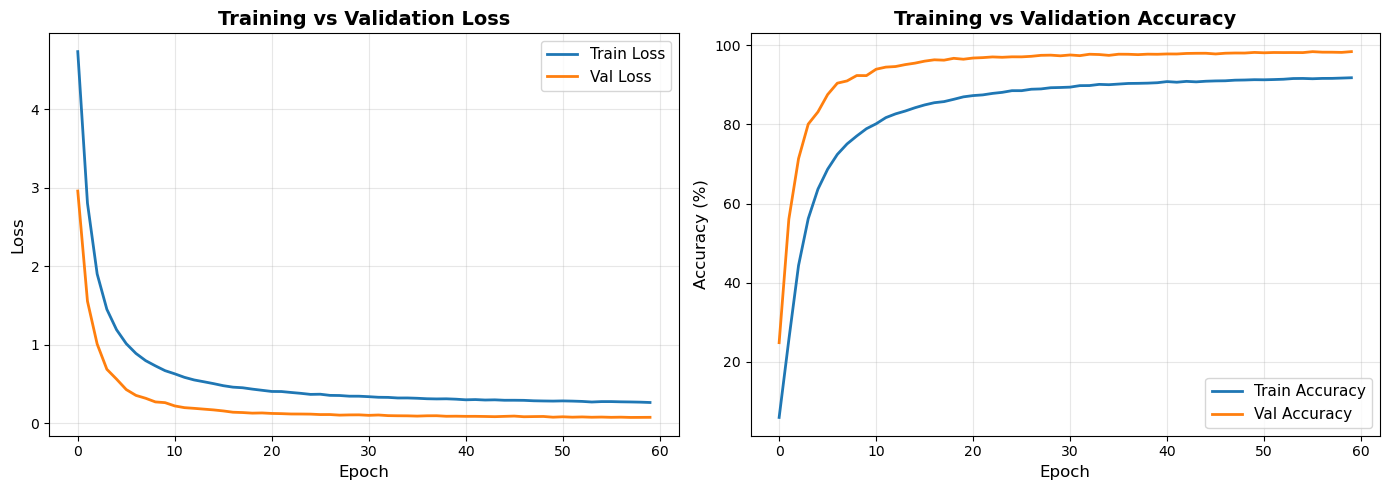


📊 Training Summary:
  Final Train Loss: 0.2643
  Final Val Loss: 0.0754
  Final Train Acc: 91.75%
  Final Val Acc: 98.35%
  Best Val Acc: 98.35% (Epoch 60)


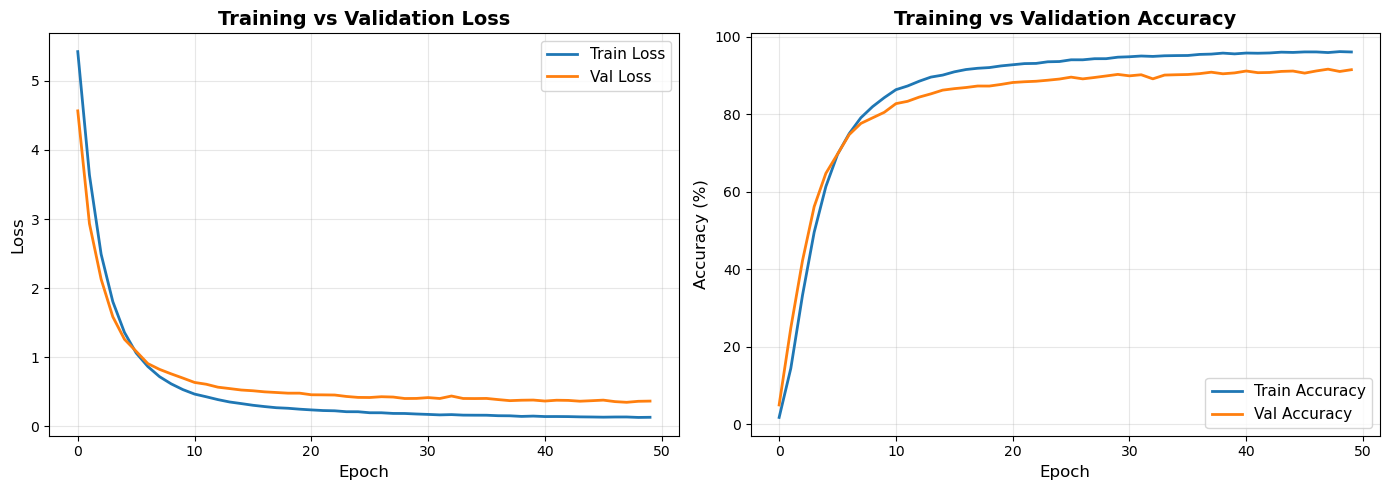


📊 Training Summary:
  Final Train Loss: 0.1296
  Final Val Loss: 0.3640
  Final Train Acc: 96.10%
  Final Val Acc: 91.52%
  Best Val Acc: 91.66% (Epoch 48)


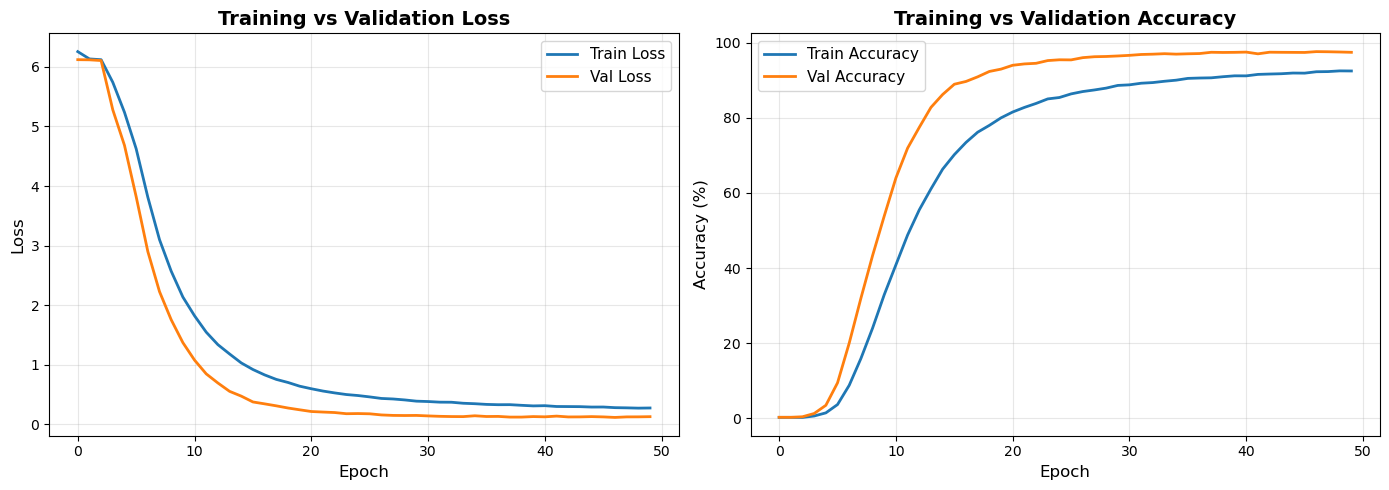


📊 Training Summary:
  Final Train Loss: 0.2738
  Final Val Loss: 0.1279
  Final Train Acc: 92.51%
  Final Val Acc: 97.49%
  Best Val Acc: 97.67% (Epoch 47)


In [13]:

plot_training_history('outputs/history/cnn_history.json')
plot_training_history('outputs/history/rnn_history.json')
plot_training_history('outputs/history/hybrid_history.json')

In [4]:
import torch
import os

# Local path where you saved your models
local_path = './outputs/models'  # Change this to your actual path


def load_model(model_class, model_name, num_classes, device):
    """
    Load a trained model from local storage.
    
    Args:
        model_class: Model class (CNNModel, RNNModel, HybridModel)
        model_name: Name of the model ('cnn', 'rnn', 'hybrid')
        num_classes: Number of classes (454 in your case)
        device: Device to load on (cuda or cpu)
    
    Returns:
        model: Loaded model
    """
    # Create empty model instance
    if model_name.lower() == 'cnn':
        model = model_class(num_classes).to(device)
    elif model_name.lower() == 'rnn':
        model = model_class(num_classes=num_classes, hidden_size=256).to(device)
    elif model_name.lower() == 'hybrid':
        model = model_class(num_classes).to(device)
    
    # Load saved weights
    model_path = os.path.join(local_path, f'{model_name}_model.pth')
    
    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}")
        return None
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    
    print(f"✓ {model_name.upper()} model loaded from: {model_path}")
    return model

In [13]:
cnn_model = load_model(CNNModel, 'cnn', 454, device)
rnn_model = load_model(RNNModel, 'rnn', 454, device)
hybrid_model = load_model(HybridModel, 'hybrid', 454, device)

✓ CNN model loaded from: ./outputs/models\cnn_model.pth
✓ RNN model loaded from: ./outputs/models\rnn_model.pth
✓ HYBRID model loaded from: ./outputs/models\hybrid_model.pth


In [15]:
print_evaluation_report(cnn_model, test_loader, 'CNN', device)
print_evaluation_report(rnn_model, test_loader, 'RNN', device)
print_evaluation_report(hybrid_model, test_loader, 'Hybrid', device)


Evaluation Report: CNN Model
Accuracy:  98.20%
Precision: 98.29%
Recall:    98.20%
F1 Score:  98.20%
Loss:      0.0826


Evaluation Report: RNN Model
Accuracy:  91.53%
Precision: 91.99%
Recall:    91.53%
F1 Score:  91.51%
Loss:      0.3531


Evaluation Report: Hybrid Model
Accuracy:  97.49%
Precision: 97.65%
Recall:    97.49%
F1 Score:  97.49%
Loss:      0.1361



{'accuracy': 0.9749449339207048,
 'precision': 0.9764513829719994,
 'recall': 0.9749449339207048,
 'f1': 0.9749473374767034,
 'loss': 0.1360841201322032}


MODEL COMPARISON

CNN:
  Accuracy:  98.20%
  Precision: 98.29%
  Recall:    98.20%
  F1 Score:  98.20%

RNN:
  Accuracy:  91.53%
  Precision: 91.99%
  Recall:    91.53%
  F1 Score:  91.51%

Hybrid:
  Accuracy:  97.49%
  Precision: 97.65%
  Recall:    97.49%
  F1 Score:  97.49%



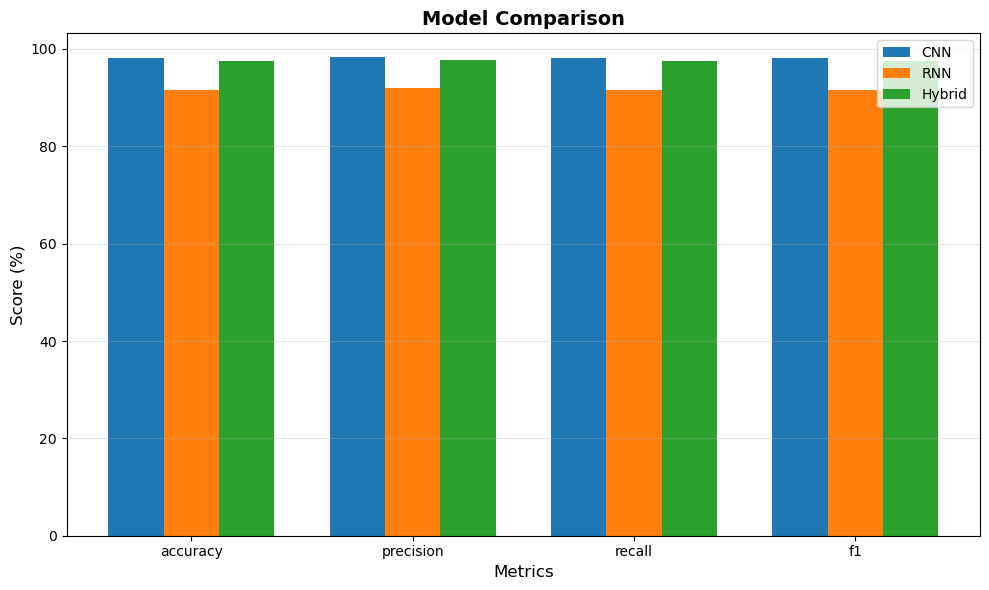

In [16]:
# Compare all models
models = {
    'CNN': cnn_model,
    'RNN': rnn_model,
    'Hybrid': hybrid_model
}
results = compare_models(models, test_loader, device)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_predictions_and_labels(model, data_loader, device):
    """Get all predictions and labels from model on a dataset."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Handle different output shapes
            if outputs.dim() == 3:
                outputs = outputs.squeeze(1)
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(preds, labels, save_path='confusion_matrix.png', figsize=(16, 14)):
    """Plot confusion matrix for multi-class classification."""
    cm = confusion_matrix(labels, preds)
    
    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return cm

def plot_confusion_matrix_normalized(preds, labels, save_path='confusion_matrix_normalized.png', figsize=(16, 14)):
    """Plot normalized confusion matrix (percentages)."""
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return cm_normalized

def evaluate_model_detailed(model, test_loader, device, class_names=None):
    """Detailed evaluation with confusion matrix and classification report."""
    preds, labels = get_predictions_and_labels(model, test_loader, device)
    
    # Accuracy
    accuracy = np.mean(preds == labels)
    
    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Classification report
    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    
    print("="*70)
    print("DETAILED EVALUATION REPORT")
    print("="*70)
    print(f"\nOverall Accuracy: {accuracy*100:.2f}%")
    print(f"Total samples: {len(labels)}")
    print(f"Correct predictions: {np.sum(preds == labels)}")
    print(f"Incorrect predictions: {np.sum(preds != labels)}")
    
    # Per-class metrics
    print("\n" + "="*70)
    print("PER-CLASS METRICS (Top 10 classes by samples)")
    print("="*70)
    
    # Get class distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    top_classes = unique_labels[np.argsort(counts)[-10:]][::-1]
    
    print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-"*70)
    
    for cls in top_classes:
        if str(cls) in report:
            metrics = report[str(cls)]
            print(f"{cls:<8} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1-score']:<12.4f} {int(metrics['support']):<10}")
    
    # Worst performing classes
    print("\n" + "="*70)
    print("WORST PERFORMING CLASSES (Lowest F1-Score)")
    print("="*70)
    
    class_f1 = {int(k): v['f1-score'] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}
    worst_classes = sorted(class_f1.items(), key=lambda x: x[1])[:5]
    
    print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-"*70)
    
    for cls, f1 in worst_classes:
        metrics = report[str(cls)]
        print(f"{cls:<8} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1-score']:<12.4f} {int(metrics['support']):<10}")
    
    return preds, labels, cm, report

